In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 13, 'ytick.labelsize': 13,
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 1200,
})

import numpy as np
from numpy.fft import fft2, fftshift, fftfreq
import torch

In [2]:
saved = torch.load('store/figs-data/TinyImageNet-C_powers.pt')

In [3]:
CORRUPTIONS = [
    'snow', 'frost', 'fog', 'brightness', 'contrast',
    'motion_blur', 'zoom_blur', 'defocus_blur', 'glass_blur',
    'elastic_transform', 'jpeg_compression', 'pixelate',
    'gaussian_noise', 'shot_noise', 'impulse_noise',
]

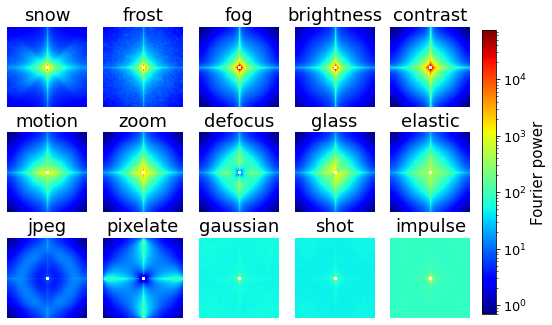

In [44]:
import matplotlib.colors as colors

severity = 5
_, axes = plt.subplots(3, 5, figsize=(10, 5.5))
vmin, vmax = np.inf, -np.inf
for i, ax in enumerate(axes.ravel()):
    corruption = CORRUPTIONS[i]
    tag = f'{corruption}-{severity}'
    powers = saved[tag]
    _vmin, _vmax = np.nanmin(powers), np.nanmax(powers)
    if _vmin<vmin:
        vmin = _vmin
    if _vmax>vmax:
        vmax = _vmax
        
for i, ax in enumerate(axes.ravel()):
    corruption = CORRUPTIONS[i]
    tag = f'{corruption}-{severity}'
    powers = saved[tag]
    # ax.imshow(np.log(powers), vmin=np.log(vmin), vmax=np.log(vmax), cmap='jet')
    h = ax.imshow(powers, norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='jet')
    ax.axis('off')
    title = corruption
    if '_' in title:
        title = title.split('_')[0]
    ax.set_title(title)
plt.colorbar(h, ax=axes, pad=0.02, shrink=0.95, label='Fourier power')
plt.show()

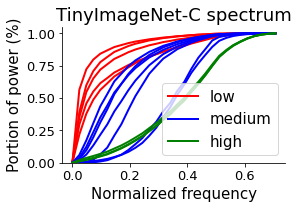

In [50]:
img_size = 64

fx, fy = np.meshgrid(fftfreq(img_size), fftfreq(img_size))
freqs = fftshift((fx**2+fy**2)**0.5)

ratios = {}
alphas = np.linspace(0, freqs.max(), 30)
for corruption in CORRUPTIONS:
    tag = f'{corruption}-{severity}'
    powers = saved[tag]
    ratios[corruption] = []
    for alpha in alphas:
        mask = freqs<=alpha
        ratios[corruption].append(np.nansum(powers[mask])/np.nansum(powers))
    # for i in range(len(alphas)-1):
    #     a_i = alphas[i]
    #     a_ip1 = alphas[i+1]
    #     mask = (freqs>a_i)&(freqs<=a_ip1)
    #     ratios[corruption].append(np.nanmean(powers[mask]))
    ratios[corruption] = np.array(ratios[corruption])

categories = {
    'low': set(['snow', 'frost', 'fog', 'brightness', 'contrast']),
    'medium': set([
        'motion_blur', 'zoom_blur', 'defocus_blur', 'glass_blur',
        'elastic_transform', 'jpeg_compression', 'pixelate',
    ]),
    'high': set(['gaussian_noise', 'shot_noise', 'impulse_noise']),
}
colors = {
    'low': 'red',
    'medium': 'blue',
    'high': 'green',
}

_, ax = plt.subplots(figsize=(4, 2.5))
lines = []
for cat in categories:
    for corruption in categories[cat]:
        h, = ax.plot(alphas, ratios[corruption], color=colors[cat])
        # h, = ax.plot(0.5*(alphas[:-1]+alphas[1:]), ratios[corruption], color=colors[cat])
    lines.append(h)
ax.set_ylim([0, None])
# ax.set_yscale('log')
ax.legend(lines, ['low', 'medium', 'high'])
ax.set_xlabel('Normalized frequency')
ax.set_ylabel('Portion of power (%)')
ax.set_title('TinyImageNet-C spectrum')
plt.show()